In [1]:
from paretoKnapsackRestaurants import *

import shutil
import matplotlib as mpl

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}"
    })
else:
    mpl.rcParams.update({"text.usetex": False})

In [2]:
# function to sample numItems from the dataset
def sample_dataset(simMatrix, item_ids, item_costs, numItems, random_seed=None):
    '''
    Samples a subset of items from the dataset.
    Args:
        simMatrix (np.ndarray): Similarity matrix of shape (N, N).
        item_ids (list): List of item IDs of length N.
        item_costs (list): List of item costs of length N.
        numItems (int): Number of items to sample.
        random_seed (int | None): Optional seed for reproducibility.
    Returns:
        sampled_simMatrix (np.ndarray): Sampled similarity matrix of shape (numItems, numItems).
        sampled_item_ids (list): List of sampled item IDs of length numItems.
        sampled_item_costs (list): List of sampled item costs of length numItems.
    '''
    rng = np.random.default_rng(random_seed)
    sampled_indices = rng.choice(len(item_ids), size=numItems, replace=False)
    sampled_simMatrix = simMatrix[np.ix_(sampled_indices, sampled_indices)]
    sampled_item_ids = [item_ids[i] for i in sampled_indices]
    sampled_item_costs = [item_costs[i] for i in sampled_indices]

    return sampled_simMatrix, sampled_item_ids, sampled_item_costs

### Yelp - Single Sample Plotting

In [3]:
def findSingleSampleSolutions(simMatrix, item_ids, item_costs, sample_size, maxBudget, dataset_name=None, random_seed=None, plot_algos=None, sample_indices=None):
    '''
    Run algorithms for one or more random samples and plot results (no averaging or interpolation).
    Args:
        simMatrix (np.ndarray): Similarity matrix of shape (N, N).
        item_ids (list): List of item IDs of length N.
        item_costs (list): List of item costs of length N.
        sample_size (int): Number of items to sample from the dataset.
        maxBudget (float): Maximum budget for the knapsack problem.
        dataset_name (str | None): Optional dataset name for output file naming.
        random_seed (int | None): Optional base seed for reproducibility.
        plot_algos (dict | None): Optional dict of algorithm name -> bool to control plotting.
        sample_indices (iterable | None): Indices of samples to run (used to offset the base seed).
    '''
    # Cost grid (same for all budgets within this sample)
    num_steps, min_cost = 15, 1
    cost_arr = np.linspace(min_cost, maxBudget, num_steps)
    algo_base = ["FC-Greedy", "ParetoGreedy", "C-Greedy", "TopK"]
    if plot_algos is None:
        plot_algos = {alg: True for alg in algo_base}
    algo_names = [alg for alg in algo_base if plot_algos.get(alg, False)]
    if sample_indices is None:
        sample_indices = [0]
    sample_indices = list(sample_indices)
    if len(sample_indices) == 0:
        raise ValueError("No valid sample indices provided.")
    def sort_pairs(costs, objs):
        if len(costs) == 0:
            return np.array([]), np.array([])
        pairs = sorted(zip(costs, objs), key=lambda x: x[0])
        return np.array([p[0] for p in pairs], dtype=float), np.array([p[1] for p in pairs], dtype=float)
    def format_points(costs, objs):
        return [f"({c:.2f}, {v:.3f})" for c, v in zip(costs, objs)]
    def align_to_cost_arr(costs, objs):
        if len(costs) == 0:
            return np.zeros_like(cost_arr, dtype=float)
        costs = np.array(costs, dtype=float)
        objs = np.array(objs, dtype=float)
        order = np.argsort(costs)
        costs = costs[order]
        objs = objs[order]
        return np.interp(cost_arr, costs, objs, left=objs[0], right=objs[-1])
    # Plot styling (consistent with averaged plotting)
    tab10_colors = plt.get_cmap("tab10").colors
    color_map = {
        "TopK": tab10_colors[4],
        "C-Greedy": tab10_colors[1],
        "ParetoGreedy": tab10_colors[3],
        "FC-Greedy": tab10_colors[0],
    }
    marker_map = {
        "TopK": "o",
        "C-Greedy": "^",
        "ParetoGreedy": "X",
        "FC-Greedy": "P",
    }
    linestyle_map = {
        "TopK": (0, (1, 1)),
        "C-Greedy": (0, (2, 2)),
        "ParetoGreedy": (0, (4, 2)),
        "FC-Greedy": (0, (2, 1, 1, 1)),
    }
    n_samples = len(sample_indices)
    n_rows, n_cols = 2, 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 8))
    axes = np.array(axes).reshape(-1)
    legend_handles = None
    legend_labels = None
    pareto_legend_handle = None
    label_map = {alg: rf"\texttt{{{alg}}}" for alg in algo_base}
    runtime_totals = {alg: 0.0 for alg in algo_base}
    rng = np.random.default_rng()
    for ax_idx, sample_idx in enumerate(sample_indices):
        ax = axes[ax_idx]
        seed = None if random_seed is None else random_seed + sample_idx
        # sample the dataset once per sample index
        sampled_simMatrix, sampled_item_ids, sampled_item_costs = sample_dataset(
            simMatrix, item_ids, item_costs, sample_size, random_seed=seed
        )
        # Pareto Greedy + FC-Greedy (computed once at full budget)
        paretoRest_full = paretoKnapsackRestaurants(n_items=sampled_item_ids,
                                                    costs=sampled_item_costs,
                                                    simMatrix=sampled_simMatrix,
                                                    budget=maxBudget)
        pg1_costs, pg1_objectives, _, pg1_time = paretoRest_full.prefixParetoGreedy_1Guess()
        fc_costs, fc_objectives, fc_time = paretoRest_full.FC_Greedy()
        # Per-budget results
        objectives = {alg: [] for alg in algo_base}
        runtimes = {alg: [] for alg in algo_base}
        for budgetVal in cost_arr:
            paretoRest = paretoKnapsackRestaurants(n_items=sampled_item_ids,
                                                   costs=sampled_item_costs,
                                                   simMatrix=sampled_simMatrix,
                                                   budget=budgetVal)
            # C-Greedy (one-guess Greedy Plus)
            _, curr_objective, curr_cost, runTime = paretoRest.oneGuessGreedyPlus()
            objectives['C-Greedy'].append(curr_objective)
            runtimes['C-Greedy'].append(runTime)
            # Top-k (add items by score until budget is exhausted)
            _, curr_objective, curr_cost, runTime = paretoRest.top_k()
            objectives['TopK'].append(curr_objective)
            runtimes['TopK'].append(runTime)
            
        runtimes['ParetoGreedy'].append(pg1_time)
        runtimes['FC-Greedy'].append(fc_time)
        # Log pareto points per algorithm
        pg_costs_sorted, pg_objs_sorted = sort_pairs(pg1_costs, pg1_objectives)
        fc_costs_sorted, fc_objs_sorted = sort_pairs(fc_costs, fc_objectives)
        logging.info("Sample %d pareto points - ParetoGreedy: %s", sample_idx, format_points(pg_costs_sorted, pg_objs_sorted))
        logging.info("Sample %d pareto points - FC-Greedy: %s", sample_idx, format_points(fc_costs_sorted, fc_objs_sorted))
        logging.info("Sample %d pareto points - C-Greedy: %s", sample_idx, format_points(cost_arr, objectives['C-Greedy']))
        logging.info("Sample %d pareto points - TopK: %s", sample_idx, format_points(cost_arr, objectives['TopK']))
        series_map = {
            "ParetoGreedy": (cost_arr, align_to_cost_arr(pg1_costs, pg1_objectives), pg1_costs),
            "FC-Greedy": (cost_arr, align_to_cost_arr(fc_costs, fc_objectives), None),
            "C-Greedy": (cost_arr, np.array(objectives['C-Greedy'], dtype=float), None),
            "TopK": (cost_arr, np.array(objectives['TopK'], dtype=float), None),
        }
        for i, alg in enumerate(algo_names):
            color = color_map.get(alg, tab10_colors[i % len(tab10_colors)])
            marker = marker_map.get(alg, 'o')
            x_vals, y_vals, scatter_costs = series_map[alg]
            marker_size = 7 if alg == "ParetoGreedy" else 6
            line_style = linestyle_map.get(alg, (0, (1, 1)))
            zorder = 4 if alg == "ParetoGreedy" else 3
            if alg == "ParetoGreedy":
                ax.plot(x_vals, y_vals,
                        label="_nolegend_",
                        color=color,
                        linestyle=line_style,
                        linewidth=1.8,
                        zorder=zorder)
                pareto_costs_unique = np.unique(np.array(scatter_costs, dtype=float)) if scatter_costs is not None else np.array([])
                pareto_costs_unique = pareto_costs_unique[(pareto_costs_unique >= cost_arr.min()) & (pareto_costs_unique <= cost_arr.max())]
                if pareto_costs_unique.size > 0:
                    keep_count = max(1, int(np.ceil(pareto_costs_unique.size * 0.75)))
                    keep_idx = rng.choice(pareto_costs_unique.size, size=keep_count, replace=False)
                    pareto_costs_unique = np.sort(pareto_costs_unique[keep_idx])
                    min_sep = 0.5 * (cost_arr[1] - cost_arr[0]) if cost_arr.size > 1 else 0
                    filtered_costs = [pareto_costs_unique[0]]
                    for c in pareto_costs_unique[1:]:
                        if c - filtered_costs[-1] >= min_sep:
                            filtered_costs.append(c)
                    pareto_costs_unique = np.array(filtered_costs, dtype=float)
                pareto_vals = np.interp(pareto_costs_unique, cost_arr, y_vals)
                ax.scatter(pareto_costs_unique, pareto_vals,
                           label="_nolegend_",
                           color=color,
                           marker=marker,
                           s=marker_size**2,
                           edgecolor='k',
                           linewidths=0.6,
                           zorder=zorder + 1)
                if ax_idx == 0:
                    from matplotlib.lines import Line2D
                    pareto_legend_handle = Line2D([0], [0],
                                                  color=color,
                                                  linestyle=line_style,
                                                  marker=marker,
                                                  markersize=marker_size,
                                                  markeredgewidth=1.1,
                                                  markeredgecolor='k',
                                                  linewidth=1.8)
            else:
                ax.plot(x_vals, y_vals,
                        label=(label_map[alg] if ax_idx == 0 else "_nolegend_"),
                        color=color,
                        linestyle=line_style,
                        marker=marker,
                        markersize=marker_size,
                        markeredgewidth=1.1,
                        markeredgecolor='k',
                        linewidth=1.8,
                        zorder=zorder)
            if alg in algo_base:
                mean = y_vals
                ax.fill_between(cost_arr,
                                np.clip(mean - 0.0, 0, None),
                                mean + 0.0,
                                color=color,
                                alpha=0.18,
                                zorder=2)
        ax.set_title("")
        ax.grid(alpha=0.3)
        ax.tick_params(axis='both', labelsize=24)
        if ax_idx == 0:
            legend_handles, legend_labels = ax.get_legend_handles_labels()
        for alg in algo_base:
            total_runtime = float(np.nansum(np.array(runtimes.get(alg, []), dtype=float)))
            runtime_totals[alg] += total_runtime
    for ax in axes[n_samples:]:
        ax.axis('off')
    if legend_handles is not None:
        handle_map = dict(zip(legend_labels, legend_handles))
        pareto_label = label_map.get("ParetoGreedy")
        if pareto_label and pareto_legend_handle is not None:
            handle_map[pareto_label] = pareto_legend_handle
        from matplotlib.lines import Line2D
        fc_label = label_map.get("FC-Greedy")
        if fc_label:
            fc_legend_handle = Line2D([0], [0],
                                      color=color_map["FC-Greedy"],
                                      linestyle=linestyle_map["FC-Greedy"],
                                      marker=marker_map["FC-Greedy"],
                                      markersize=8,
                                      markeredgewidth=1.1,
                                      markeredgecolor='k',
                                      linewidth=1.8)
            handle_map[fc_label] = fc_legend_handle
        ordered_labels = [
            label_map["FC-Greedy"],
            label_map["ParetoGreedy"],
            label_map["C-Greedy"],
            label_map["TopK"],
        ]
        ordered_handles = [handle_map[l] for l in ordered_labels if l in handle_map]
        fig.legend(ordered_handles, ordered_labels, loc='upper center', ncol=4, fontsize=18, frameon=True)
    for r in range(n_rows):
        for c in range(n_cols):
            idx = r * n_cols + c
            if idx >= len(axes):
                continue
            ax = axes[idx]
            if r == n_rows - 1:
                ax.set_xlabel(r'Cost, $c_\ell$', fontsize=24)
            if c == 0:
                ax.set_ylabel(r'Objective, $f$', fontsize=24)
    fig.tight_layout(rect=[0.03, 0.03, 1, 0.9])
    # Save figure
    from pathlib import Path
    base_dir = Path.cwd().resolve().parents[1]
    plots_dir = base_dir / "plots" / "knapsack" / "single"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_knapsack_single_sample.pdf"
    fig.savefig(out_path, bbox_inches="tight")
    plt.show()
    # Runtime summary (seconds)
    runtime_lines = ["Runtime summary (seconds):"]
    for alg in algo_names:
        total_runtime = float(np.nansum(np.array(runtime_totals.get(alg, []), dtype=float)))
        runtime_lines.append(f"  - {alg}: {total_runtime:.3f}")
    print("\n".join(runtime_lines))

### Yelp Phoenix Single Sample

In [4]:
# Import Yelp dataset
data_path = '../../datasets/pickled_data/yelp/yelp_phoenix_'

# Import pickled data
with open(data_path + 'ids.pkl', "rb") as fp:
    phoenix_ids = pickle.load(fp)

with open(data_path + 'sim.pkl', "rb") as fp:
    phoenix_simMatrix = pickle.load(fp)

with open(data_path + 'costs.pkl', "rb") as fp:
    phoenix_costs = pickle.load(fp)

2026-02-06 18:11:00,396 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:40, Budget=125
2026-02-06 18:11:01,414 |INFO: Cost epsilon grid: eps=0.100, min_cost=0.119, max_budget=125.000, points=74
2026-02-06 18:11:12,854 |INFO: CoverageLinear epsilon grid: eps=0.100, min_obj=1.846, max_obj=40.000, points=34
2026-02-06 18:11:13,082 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:40, Budget=1.0
2026-02-06 18:11:13,086 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:40, Budget=9.857142857142858
2026-02-06 18:11:13,141 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:40, Budget=18.714285714285715
2026-02-06 18:11:13,271 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:40, Budget=27.571428571428573
2026-02-06 18:11:13,524 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:40, Budget=36.42857142857143
2026-02-06 18:11:13,900 |INFO: Initialized Pareto R

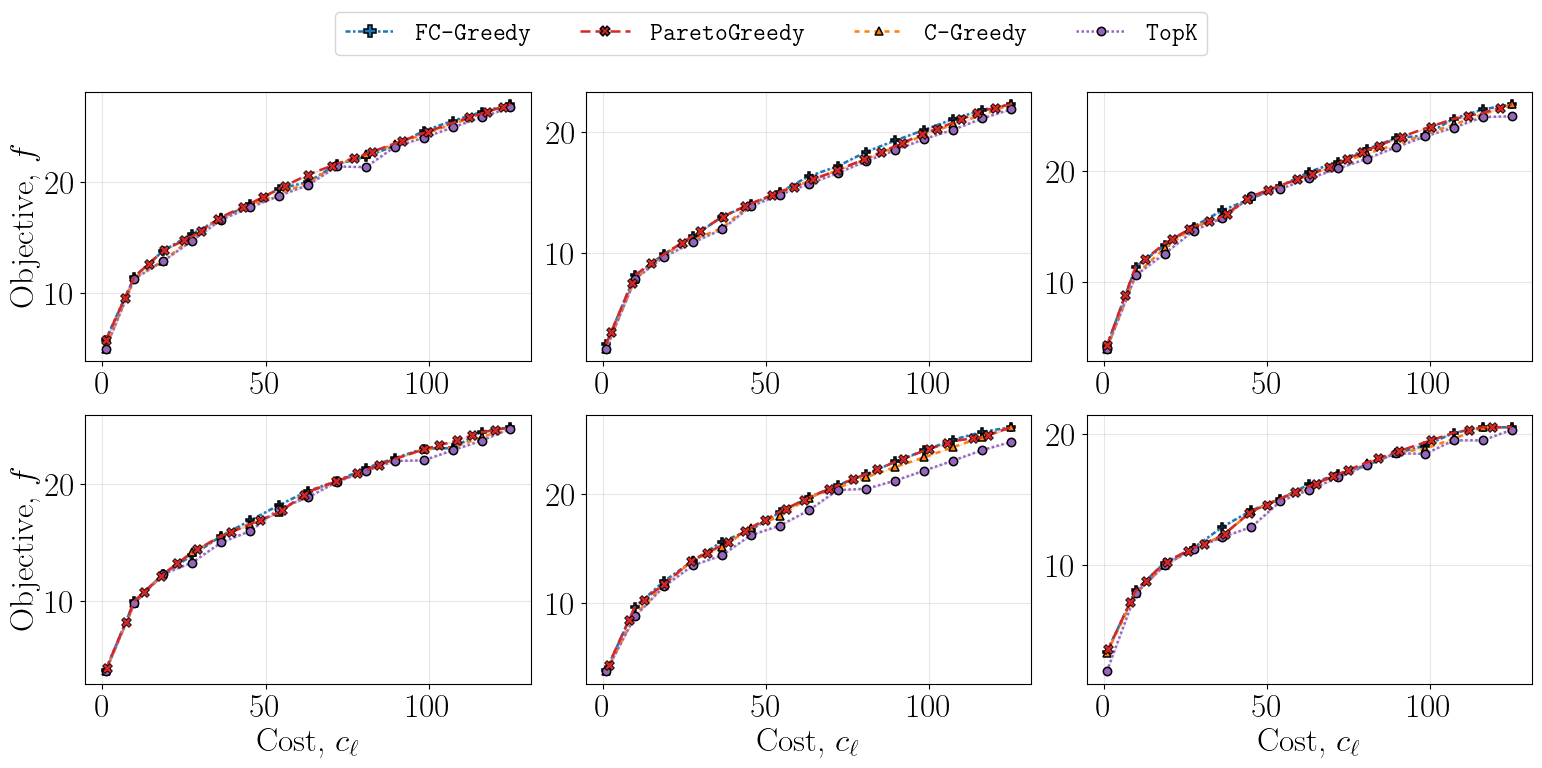

Runtime summary (seconds):
  - FC-Greedy: 58.858
  - ParetoGreedy: 4.982
  - C-Greedy: 40.250
  - TopK: 0.043


In [5]:
# Call findSingleSampleSolutions (adjust parameters as needed)
sample_size = 40
maxBudget = 125
random_seed = 42

plot_algos = {
    "FC-Greedy": True,
    "ParetoGreedy": True,
    "C-Greedy": True,
    "TopK": True
}

findSingleSampleSolutions(
    phoenix_simMatrix, phoenix_ids, phoenix_costs,
    sample_size, maxBudget,
    dataset_name="Yelp-PHX",
    random_seed=random_seed,
    plot_algos=plot_algos,
    sample_indices=range(6)
 )

### Yelp Vegas Single Sample

In [6]:
# Import Vegas dataset
data_path = '../../datasets/pickled_data/yelp/yelp_vegas_' 

# Import pickled data
with open(data_path + 'ids.pkl', "rb") as fp:
    vegas_ids = pickle.load(fp)

with open(data_path + 'sim.pkl', "rb") as fp:
    vegas_simMatrix = pickle.load(fp)

with open(data_path + 'costs.pkl', "rb") as fp:
    vegas_costs = pickle.load(fp)

2026-02-06 18:12:46,546 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=125
2026-02-06 18:12:48,095 |INFO: Cost epsilon grid: eps=0.100, min_cost=0.952, max_budget=125.000, points=53
2026-02-06 18:13:05,859 |INFO: CoverageLinear epsilon grid: eps=0.100, min_obj=1.813, max_obj=50.000, points=36
2026-02-06 18:13:06,194 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=1.0
2026-02-06 18:13:06,196 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=9.857142857142858
2026-02-06 18:13:06,221 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=18.714285714285715
2026-02-06 18:13:06,390 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=27.571428571428573
2026-02-06 18:13:06,741 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=36.42857142857143
2026-02-06 18:13:07,212 |INFO: Initialized Pareto R

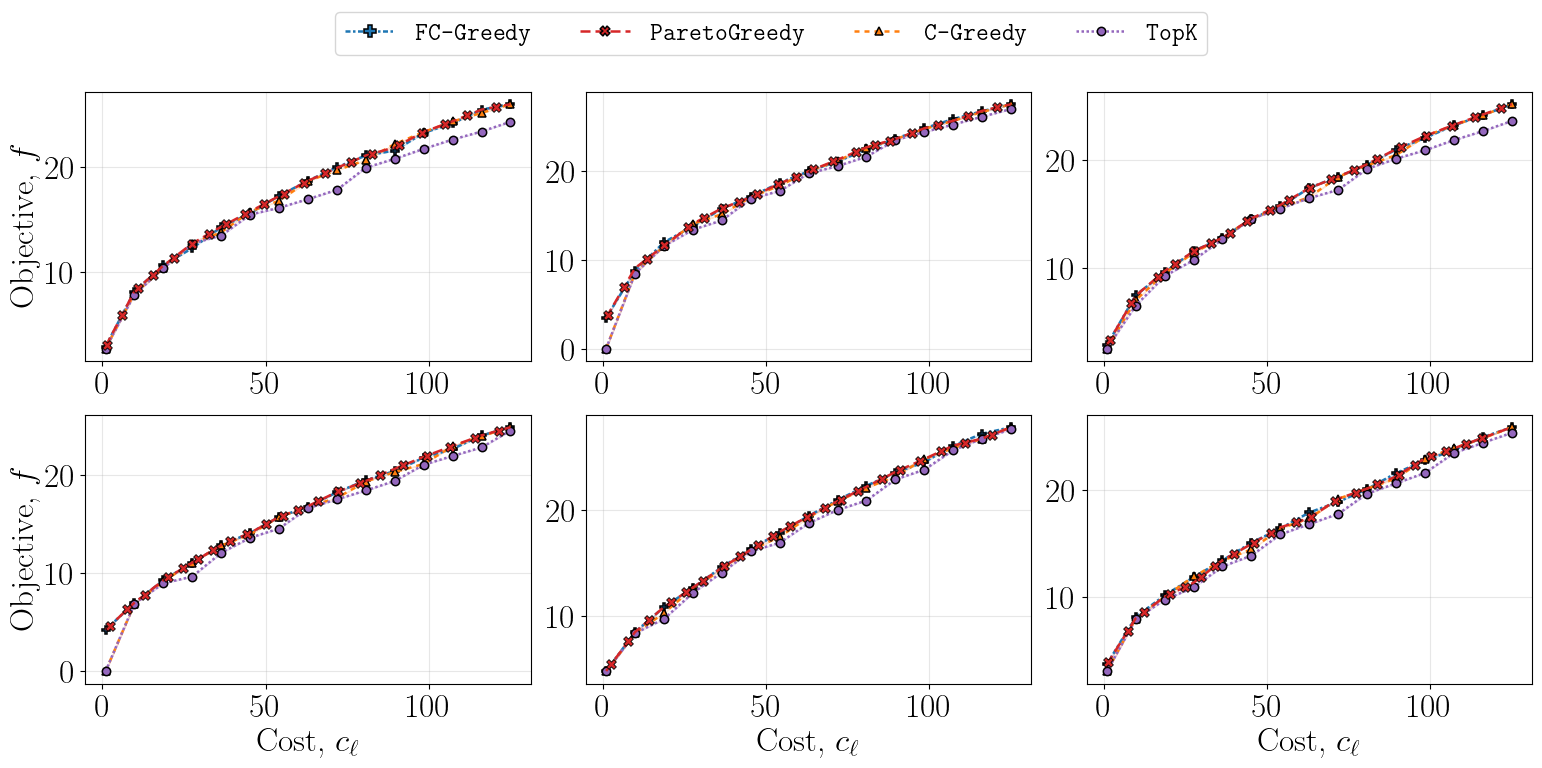

Runtime summary (seconds):
  - FC-Greedy: 103.424
  - ParetoGreedy: 9.626
  - C-Greedy: 73.512
  - TopK: 0.051


In [7]:
# Call findSingleSampleSolutions (adjust parameters as needed)
sample_size = 50
maxBudget = 125
random_seed = 42

findSingleSampleSolutions(
    vegas_simMatrix, vegas_ids, vegas_costs,
    sample_size, maxBudget,
    dataset_name="Yelp-LV",
    random_seed=random_seed,
    plot_algos=plot_algos,
    sample_indices=range(6)
 )